In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [2]:
import functools
import glob
import math
import torch
import ants
import antspynet
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors


from functools import partial
from scipy.ndimage import median_filter
import skimage.filters as skf
from scipy.stats import percentileofscore

import yaml
from nilearn import datasets, plotting
import os 

2024-04-02 21:51:03.694880: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 21:51:03.697716: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 21:51:03.731868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# #####
CACHE_DIR = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/"

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"

# if not os.path.exists(procd_ref_img_path):
T1_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd"
)
T2_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd"
)
MASK_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd"
)

ants_mni = ants.image_read(f"{CACHE_DIR}/croppedMni152.nii.gz")
t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

# Use ANTs' tighter cropping
diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
crop_idxs_start, crop_idxs_end = 1 + diff // 2, np.array(t1_ref_img.shape) - diff // 2

t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end)
t2_ref_img = ants.crop_indices(t2_ref_img, crop_idxs_start, crop_idxs_end)
ref_img_mask = ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end)

procd_ref_img = ants.merge_channels((t1_ref_img * ref_img_mask, t2_ref_img * ref_img_mask))
procd_ref_img.to_filename(procd_ref_img_path)

In [4]:
def register_to_mni(x:np.ndarray, fname: str):
    x = ants.from_numpy(x)
    sampleid = os.path.basename(fname).split(".nii.gz")[0]
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    ).numpy()

In [5]:
# @jit(nopython=True)
def count(x):
    return np.count_nonzero(x, axis=0)

# @jit(nopython=True)
def vec_pscore(score, reference_scores):
    """
    Computes the percentile of a given tensor x at each position with respect to a reference tensor
    Args:
        x: Tensor of shape (b, h, w, d)
        reference_scores: Tensor of shape (b, h, w, d)
    Returns:
        percentiles: Tensor of shape (b, h, w, d)
    """

    n = reference_scores.shape[0]
    
    # Prepare broadcasting
    reference_scores = reference_scores[:, None, ...]

    left = count(reference_scores < score)
    right = count(reference_scores <= score)
    plus1 = left < right
    perct = (left + right + plus1) * (50.0 / n)
    return perct

In [6]:
from sade.configs.flows import ve_flow_config as configs
from sade.datasets.loaders import get_image_files_list, get_val_transform, get_lesion_transform
from sade.metrics import erode_brain_masks

config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"
transforms_dir = f"/DATA/Users/amahmood/braintyp/spacing_{int(config.data.spacing_pix_dim)}"
unscale = lambda x: (x+1)/2

img_loader = get_val_transform(config)
img_and_label_loader = get_lesion_transform(config)

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"
ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
ref_img_post_transform = unscale(ants.from_numpy(ref_img_tensor[0]))

In [7]:
bmask = (ref_img_post_transform.numpy() > 0).astype(float)
BRAIN_MASK = ants.from_numpy(bmask)
# ERODED_BRAIN_MASK = ants.from_numpy(erode_brain_masks(BRAIN_MASK[None,...].numpy(),radius=2)[0])

### Load the data

In [8]:
dataset_dir = config.data.dir_path
# Directory that holds files with train/test splits and other filenames
splits_dir = config.data.splits_dir
config.data

cache_rate: 0.0
dataset: ABCD
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
spacing_pix_dim: 2.0
splits_dir: /codespace/sade/sade/datasets/brains/

In [9]:
inlier_files_remote = get_image_files_list("ibis-inlier", dataset_dir, "/ASD/ahsan_projects/braintypicality/dataset/dataset_split_builder/")
inlier_files_remote

[{'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS108372.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS114640.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS119906.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS136262.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS142306.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS160908.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS162756.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS167799.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS171870.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS186041.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS186588.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS218286.nii.gz'},
 {'image': '/DATA/Users/amahmood/braintyp/processed_v2/IBIS236316.nii.gz'},
 {'image': '

In [10]:
abcd_train_files = get_image_files_list("abcd-train", dataset_dir, splits_dir)
abcd_val_files = get_image_files_list("abcd-val", dataset_dir, splits_dir)
abcd_test_files = get_image_files_list("abcd-test", dataset_dir, splits_dir)

ibis_inlier_files = get_image_files_list("ibis-inlier", dataset_dir, splits_dir)
ibis_ds_files = get_image_files_list("ibis-ds-sa", dataset_dir, splits_dir)
ibis_hr_files = get_image_files_list("ibis-hr-inlier", dataset_dir, splits_dir)
ibis_atyp_files = get_image_files_list("ibis-atypical", dataset_dir, splits_dir)
ibis_asd_files = get_image_files_list("ibis-asd", dataset_dir, splits_dir)

In [11]:
extract_ids = lambda f: f.split("/")[-1].replace('.nii.gz', '')
extract_ids(ibis_ds_files[0]["image"])

'IBIS105477'

In [12]:
len(abcd_train_files)

1320

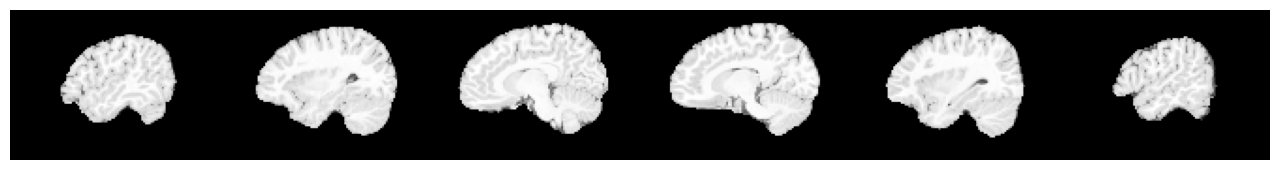

In [13]:
fname = ibis_asd_files[0]["image"]
img_tensor = img_loader({"image": fname})["image"].numpy()
t1 = unscale(ants.from_numpy(img_tensor[0]))
t1.plot(nslices=6)

In [14]:
# %%time
# reg_dict = ants.registration(fixed=ref_img_post_transform, moving=t1_img,
#                              type_of_transform = 'SyN')


# t1_reg = ants.apply_transforms(
#         fixed=ref_img_post_transform, moving=t1_img,
#         transformlist=reg_dict["fwdtransforms"], interpolator="linear",
#     verbose=True
# )

['-d', '3', '-i', '0x55dc83943f70', '-o', '0x55dc8393eff0', '-r', '0x55dc8393de30', '-n', 'linear', '-t', '/DATA/Users/amahmood/braintyp/spacing_2/IBIS107524Composite.h5']
Using single precision for computations.
Input scalar image: 0x55dc83943f70
Reference image: 0x55dc8393de30
The composite transform comprises the following transforms (in order): 
  1. /DATA/Users/amahmood/braintyp/spacing_2/IBIS107524Composite.h5[0] (type = AffineTransform)
  2. /DATA/Users/amahmood/braintyp/spacing_2/IBIS107524Composite.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: 0x55dc8393eff0


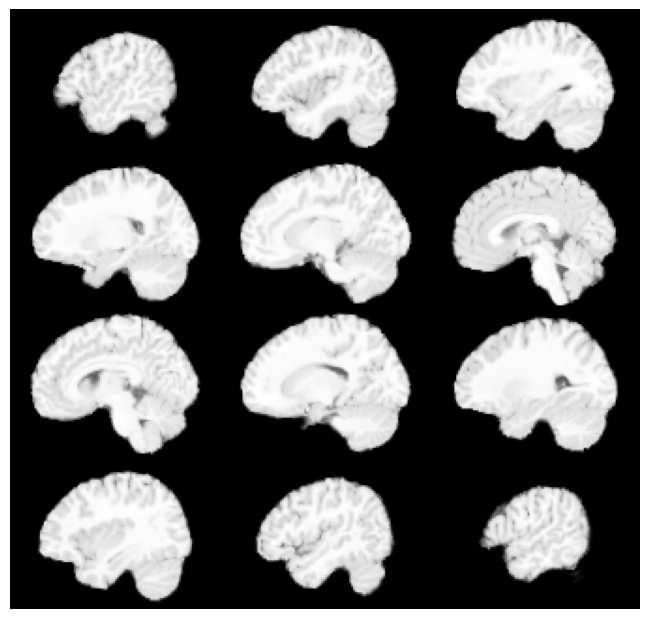

In [15]:
sampleid = os.path.basename(fname).split(".nii.gz")[0]
transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
t1_reg = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=t1,
        transformlist=transform_mat, interpolator="linear",verbose=True
)
t1_reg.plot()

In [16]:
# flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg200_nb20_long/eval/ckpt_6040/'
flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow/psz3-globalpsz17-nb20-lr0.0003-bs32-np1024-kimg300_smin1e-2_smax0.8/eval/ckpt_9240/'
%ls $flow_path

abcd-test_lesion_load_20-enhanced_results.npz
abcd-test_lesion_load_20-enhanced_seg_eval.csv
abcd-test_lesion_load_20-enhanced_segs.npz
abcd-val_lesion_load_20_results.npz
ibis-hr-inlier_ibis-ds-sa_results.npz
ibis-inlier_ibis-asd_results.npz
ibis-inlier_ibis-atypical_results.npz


In [17]:
%%time

experiment = config.eval.experiment

config.eval.experiment.inlier = "ibis-hr-inlier"
config.eval.experiment.ood = "ibis-ds-sa"
experiment_name = f"{experiment.inlier}_{experiment.ood}"

data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_hr_inlier_scores = data["inliers"]
x_ds_scores = data["ood"]

CPU times: user 3.88 s, sys: 370 ms, total: 4.25 s
Wall time: 4.25 s


In [18]:
config.eval.experiment.inlier = "ibis-inlier"
config.eval.experiment.ood = "ibis-atypical"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_inlier_scores = data["inliers"]
x_atypical_scores = data["ood"]

In [19]:
config.eval.experiment.inlier = "ibis-inlier"
config.eval.experiment.ood = "ibis-asd"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_asd_scores = data["ood"]

In [20]:
x_inlier_scores.shape

(82, 96, 112, 80)

### Reference Scores

In [21]:
config.eval.experiment.inlier = "abcd-val"
config.eval.experiment.ood = "lesion_load_20"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_abcd_val_scores = data["inliers"]

config.eval.experiment.inlier = "abcd-test"
config.eval.experiment.ood = "lesion_load_20-enhanced"
experiment_name = f"{experiment.inlier}_{experiment.ood}"
data = np.load(f"{flow_path}/{experiment_name}_results.npz", allow_pickle=True)
x_abcd_test_scores = data["inliers"]

In [22]:
# %%time
# data = np.load(f"{flow_path}/percentile_scores.npz", allow_pickle=True)
# x_inlier_percentiles = data["inliers"]
# x_ds_percentiles = data["ds"]
# x_hr_percentiles = data["hr"]
# x_atyp_percentiles = data["atypical"]

In [23]:
%%time
x_abcd_val_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_abcd_val_scores, abcd_val_files)]
x_abcd_test_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_abcd_test_scores, abcd_test_files)]

CPU times: user 1min 50s, sys: 15.1 s, total: 2min 5s
Wall time: 1min 34s


In [24]:
%%time
x_inlier_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_inlier_scores, ibis_inlier_files)]

CPU times: user 27.3 s, sys: 3.67 s, total: 30.9 s
Wall time: 22.9 s


In [25]:
%%time
x_hr_inlier_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_hr_inlier_scores, ibis_hr_files)]

CPU times: user 35.2 s, sys: 4.61 s, total: 39.8 s
Wall time: 29 s


In [26]:
%%time
x_ds_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_ds_scores, ibis_ds_files)]

CPU times: user 9.3 s, sys: 1.31 s, total: 10.6 s
Wall time: 7.85 s


In [27]:
%%time
x_atypical_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_atypical_scores, ibis_atyp_files)]

CPU times: user 12.4 s, sys: 1.59 s, total: 14 s
Wall time: 10.2 s


In [28]:
%%time
x_asd_scores_aligned = [register_to_mni(x, fname["image"]) for x, fname in zip(x_asd_scores, ibis_asd_files)]

CPU times: user 21.4 s, sys: 2.83 s, total: 24.2 s
Wall time: 17.9 s


In [29]:
# ds_var = np.var([x for x in x_ds_scores_aligned], axis=0)
# # minq, maxq = np.quantile(inlier_avg, [0.5, 0.999])
# # inlier_avg = np.clip(inlier_avg, minq, maxq)
# # inlier_avg = ants.from_numpy(inlier_avg) * (ref_img_post_transform > 0)
# ants.plot(image=ants.from_numpy(ds_var) , cmap="OrRd", cbar=True, nslices=6)

In [30]:
# inlier_mean_var.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps/inlier_mean_var.nii.gz")
# ds_mean_var.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps/ds_mean_var.nii.gz")
# inlier_quantiles.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps/inlier_quantiles.nii.gz")
# ds_quantiles.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps/ds_quantiles.nii.gz")

### Using 3x3x3 Median filter

In [31]:
# %%time
# reference_scores = np.concatenate((x_abcd_val_scores_aligned, x_abcd_test_scores_aligned), axis=0)
# reference_scores = torch.from_numpy(reference_scores)#.cuda()
# reference_scores = torch.nn.functional.avg_pool2d(reference_scores, kernel_size=3, padding=1, stride=1).numpy()
# reference_scores.shape

In [32]:
%%time
reference_scores = np.concatenate((x_abcd_val_scores_aligned, x_abcd_test_scores_aligned), axis=0)
# reference_scores = skf.median(reference_scores, footprint=np.ones((1,3,3,3)), mode='constant')
reference_scores.shape

CPU times: user 916 ms, sys: 491 ms, total: 1.41 s
Wall time: 1.41 s


(330, 96, 112, 80)

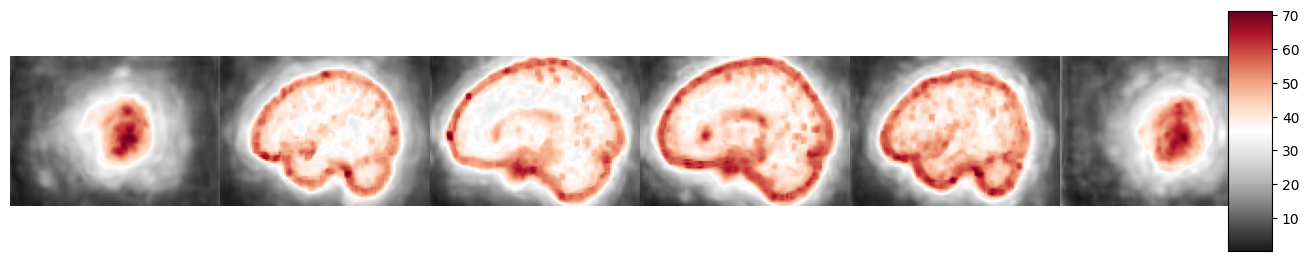

In [33]:
x = reference_scores[4]
x = x - x.min()
x = ants.from_numpy(x)
x.plot(nslices=6, cmap="RdGy_r", cbar=True)

In [34]:
avg_reference_score = ants.from_numpy(np.mean(reference_scores, axis=0))
# avg_reference_score.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/ref_mean.nii.gz")

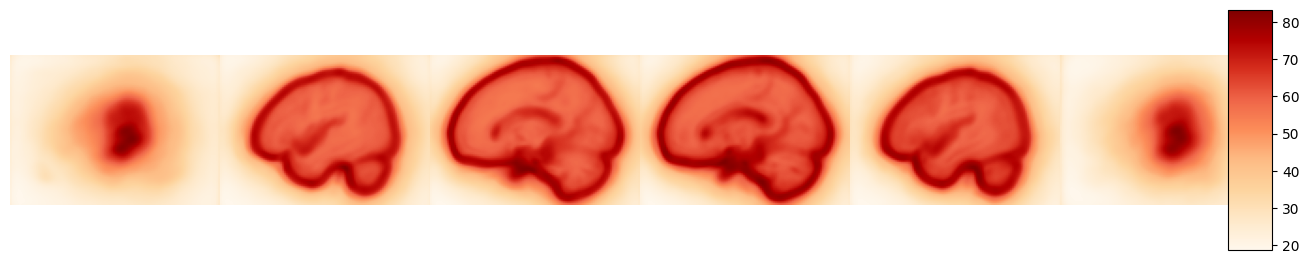

In [35]:
ants.plot(image=avg_reference_score+100 , cmap="OrRd", cbar=True, nslices=6)

In [36]:
ds_mean = np.mean(x_ds_scores_aligned, axis=0)
ds_mean_pct = ants.from_numpy(vec_pscore(ds_mean, reference_scores)[0])
# ds_mean_pct.to_filename("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/ds_mean.nii.gz")

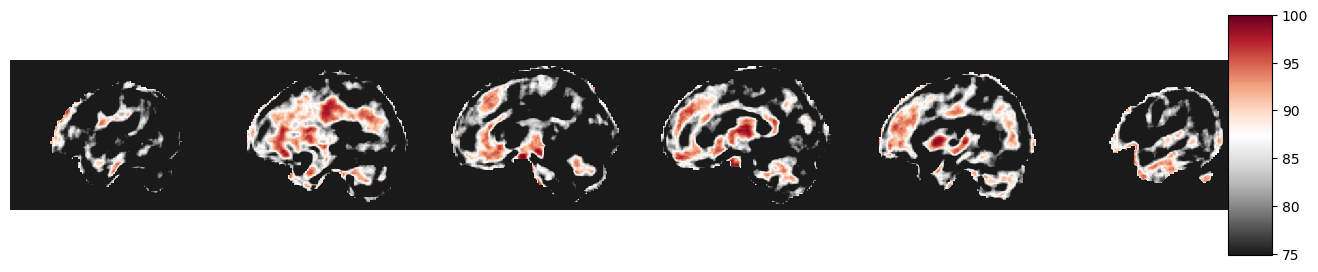

In [37]:
ants.plot(image=ds_mean_pct * BRAIN_MASK  , cmap="RdGy_r", cbar=True, nslices=6, scale=(0.5,1.0))

# Getting Parcellation Scores 

### Using AntsPyNet deep learning model based parcellation

In [38]:
%%time
# Should only need to do this once...
dkt_precomputed_path = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/dkt.nii.gz"
if os.path.exists(dkt_precomputed_path):
    dkt_raw = ants.image_read(dkt_precomputed_path)
else:
    t1_ref_img, _ = ants.image_read(procd_ref_img_path).split_channels()
    dkt_raw = antspynet.utilities.desikan_killiany_tourville_labeling(t1_ref_img, do_preprocessing=True, verbose=False)
    dkt_raw.to_filename(dkt_precomputed_path)

dkt_post = img_and_label_loader({"image": procd_ref_img_path, "label": dkt_precomputed_path})["label"][0].numpy()
dkt_post = ants.from_numpy(dkt_post)

CPU times: user 2.07 s, sys: 530 ms, total: 2.6 s
Wall time: 864 ms


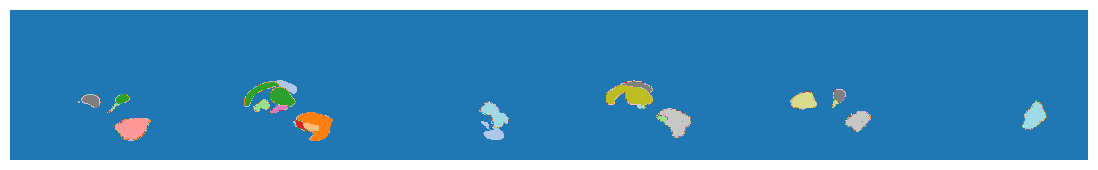

In [39]:
(dkt_raw * (dkt_raw < 1000)).plot(cmap="tab20", nslices=6)

In [40]:
with open("dkt_labels.yaml", "r") as f:
    dkt_labels = yaml.safe_load(f)

dkt_labels_flattened = {k:v for regions, labels in dkt_labels.items() for k,v in labels.items()}
len(dkt_labels_flattened)

102

In [41]:
CSF = 1

In [42]:
atropos_precomputed_path = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/atropos.nii.gz"
if os.path.exists(atropos_precomputed_path):
    atropos = ants.image_read(atropos_precomputed_path)
else:
    t1_ref_img, _ = ants.image_read(procd_ref_img_path).split_channels()
    atropos = antspynet.utilities.deep_atropos(t1_ref_img, do_preprocessing=True, verbose=False)
    atropos['segmentation_image'].to_filename(atropos_precomputed_path)
    x = atropos['probability_images'][1]
    x.plot(cmap="jet", cbar=True)

In [43]:
%%time
atropos_img = ants.resample_image(atropos, ref_img_post_transform.shape, use_voxels=True, interp_type=1)
atropos_img.set_spacing((1.0,1.0,1.0))
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=atropos_img,
                             type_of_transform = 'SyN', interpolator="nearest")
atropos_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=atropos_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
atropos_transformed

['-d', '3', '-i', '0x55dd0b75e970', '-o', '0x55dd0b75e990', '-r', '0x55dd0dd2e710', '-n', 'multiLabel', '-t', '/tmp/tmpmu6nzljt1Warp.nii.gz', '-t', '/tmp/tmpmu6nzljt0GenericAffine.mat']
Using single precision for computations.
Input scalar image: 0x55dd0b75e970
Reference image: 0x55dd0dd2e710
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpmu6nzljt0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpmu6nzljt1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x55dd0b75e990
CPU times: user 26.4 s, sys: 1.3 s, total: 27.7 s
Wall time: 4.91 s


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [44]:
atropos_post = img_and_label_loader({"image": procd_ref_img_path, "label": atropos_precomputed_path})["label"][0].numpy()
atropos_post = ants.from_numpy(atropos_post)
atropos_post

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

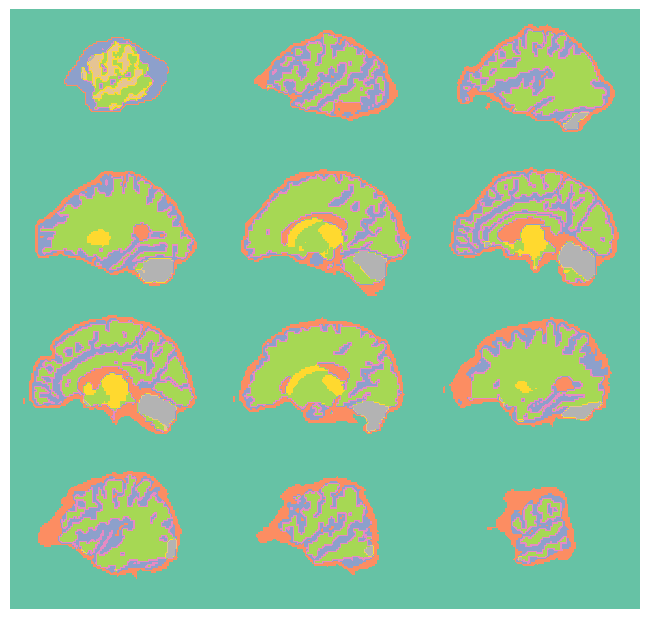

In [45]:
atropos_post.plot(cmap="Set2")

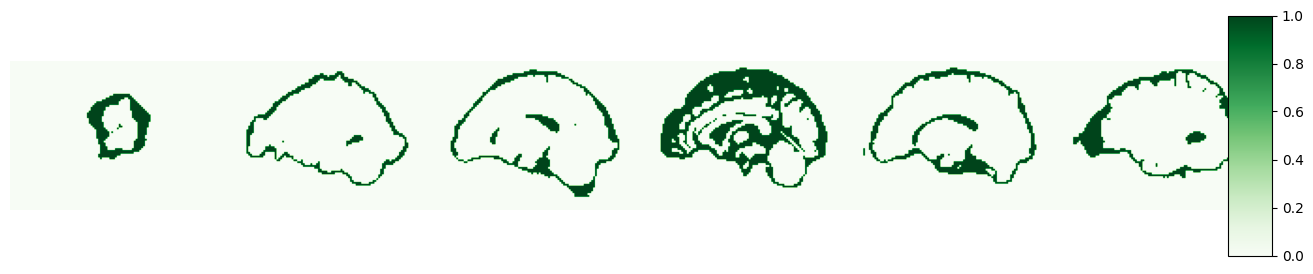

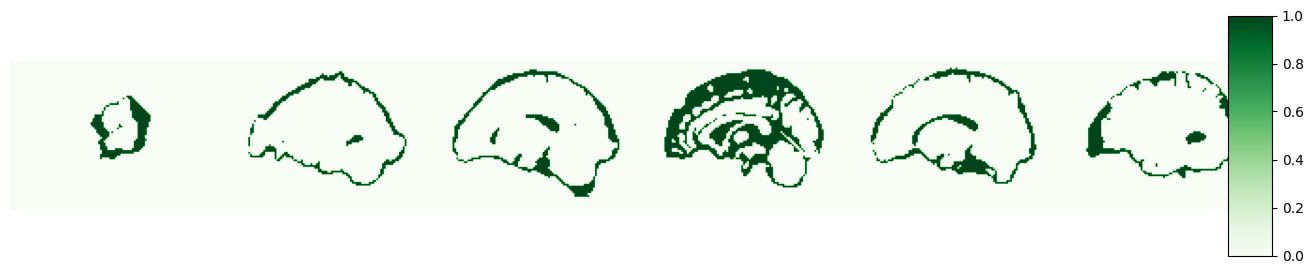

In [46]:
plotslices = [16,32,40,48,56,64]
(atropos_post * (atropos_post == CSF)).plot(cmap="Greens", cbar=True, slices=plotslices)
(atropos_post * ((atropos_post*BRAIN_MASK) == CSF)).plot(cmap="Greens", cbar=True, slices=plotslices)

### Using Atlases

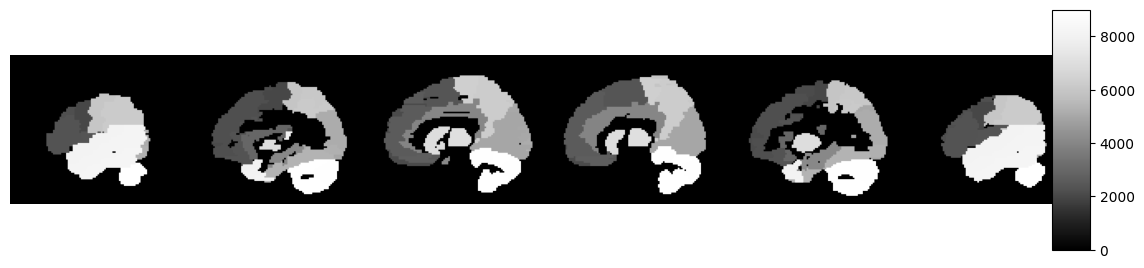

In [47]:
aal = datasets.fetch_atlas_aal(version='SPM12', data_dir=os.path.join(CACHE_DIR,"atlases"))
aal_img = ants.image_read(aal.maps, pixeltype='unsigned int')
aal_img.set_spacing((1.0,1.0,1.0))
aal_img.plot(nslices=6, cbar=True)

In [48]:
aal_img

ANTsImage (RPI)
	 Pixel Type : unsigned int (uint32)
	 Components : 1
	 Dimensions : (91, 109, 91)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [49]:
%ls $CACHE_DIR

S_template3.nii.gz           brainExtractionT2.h5
atlases/                     croppedMni152.nii.gz
atropos.nii.gz               croppedMni152Priors.nii.gz
brainExtraction.h5           cropped_niral_mni.nii.gz
brainExtractionNoBrainer.h5  dkt.nii.gz
brainExtractionRobustT1.h5   mni_icbm152_09a/
brainExtractionRobustT2.h5   ref_brain.npy
brainExtractionT1v1.h5       sixTissueOctantBrainSegmentationWithPriors1.h5


In [50]:
label_df = pd.DataFrame(aal.labels, aal.indices, columns=['ROI-Name'])
label_df.to_csv('aal_labels.csv', index_label='ROI-Index')

In [51]:
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=aal_img,
                             type_of_transform = 'SyN', interpolator="nearest")
aal_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=aal_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
aal_transformed

['-d', '3', '-i', '0x55dc8369e600', '-o', '0x55dc83844c70', '-r', '0x55dc8409f1a0', '-n', 'multiLabel', '-t', '/tmp/tmpuzjj6x7e1Warp.nii.gz', '-t', '/tmp/tmpuzjj6x7e0GenericAffine.mat']
Using single precision for computations.
Input scalar image: 0x55dc8369e600
Reference image: 0x55dc8409f1a0
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpuzjj6x7e0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpuzjj6x7e1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x55dc83844c70


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

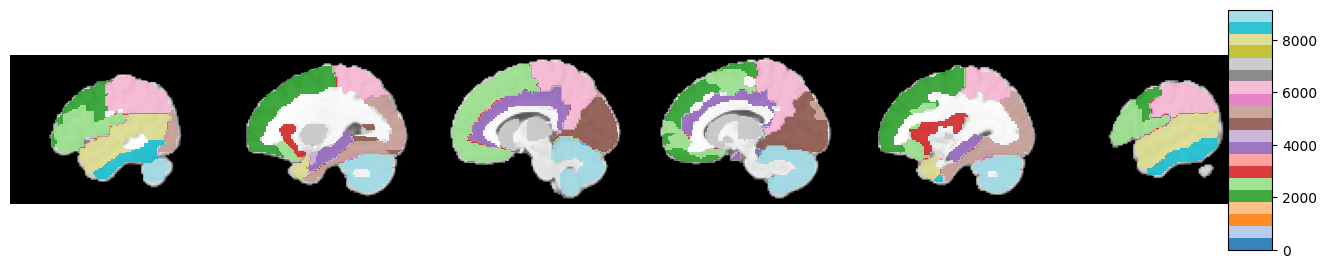

In [52]:
ref_img_post_transform.plot(overlay=aal_transformed, nslices=6, cbar=True, overlay_cmap="tab20")

6001 Postcentral_L


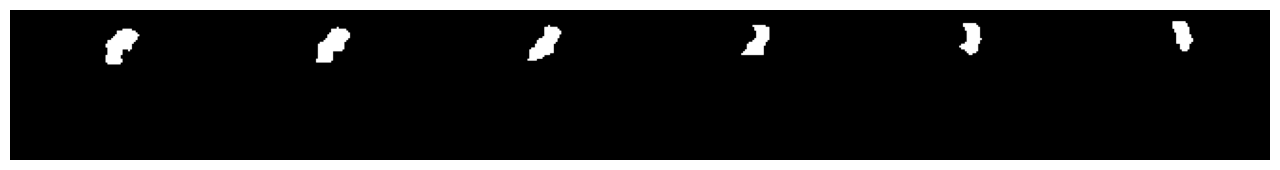

In [53]:
for indx, label in zip(aal.indices, aal.labels):
    if int(indx) < 6000: continue
    print(indx, label)
    (aal_transformed*((aal_transformed == int(indx))*1.0)).plot(nslices=6)
    break

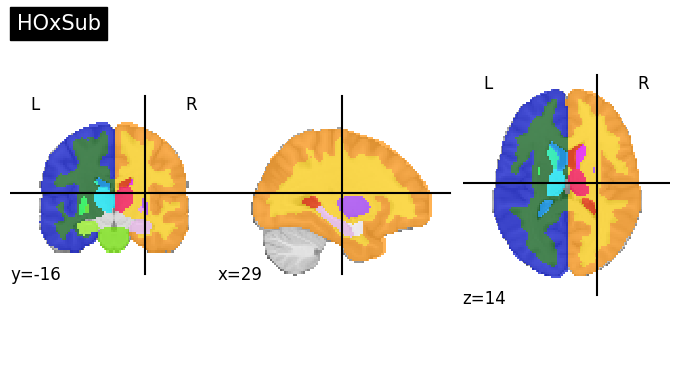

In [54]:
atlas_name = 'sub-maxprob-thr25-2mm'
harvard_oxford_subcortical = datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir=os.path.join(CACHE_DIR,"atlases"))
plotting.plot_roi(harvard_oxford_subcortical.maps, title="HOxSub")

['-d', '3', '-i', '0x55dc83a3cbc0', '-o', '0x55dc83a3cc40', '-r', '0x55dc5cb5d140', '-n', 'multiLabel', '-t', '/tmp/tmpkpdppalv1Warp.nii.gz', '-t', '/tmp/tmpkpdppalv0GenericAffine.mat']
Using single precision for computations.
Input scalar image: 0x55dc83a3cbc0
Reference image: 0x55dc5cb5d140
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpkpdppalv0GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpkpdppalv1Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x55dc83a3cc40


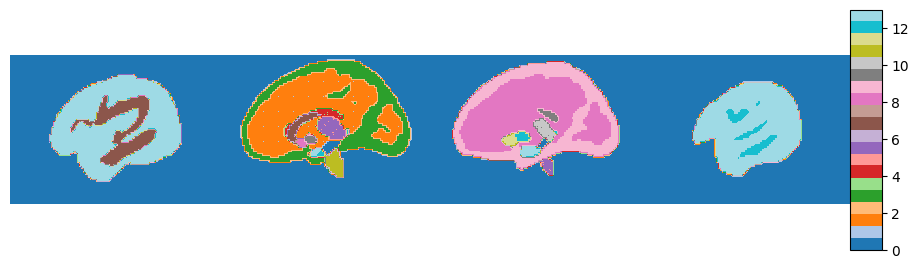

In [55]:
harvard_subcortical_labels = ants.from_nibabel(harvard_oxford_subcortical.maps)
harvard_subcortical_labels.set_spacing((1.0,1.0,1.0))
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=harvard_subcortical_labels,
                             type_of_transform = 'SyN', interpolator="nearest")
harvard_subcortical_labels_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=harvard_subcortical_labels,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
harvard_subcortical_labels_transformed.plot(nslices=4, cmap="tab20", cbar=True)

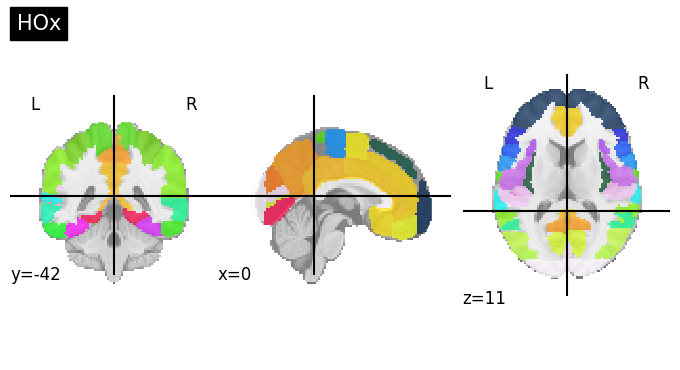

In [56]:
atlas_name = 'cort-maxprob-thr25-2mm'
harvard_oxford_cortical = datasets.fetch_atlas_harvard_oxford(atlas_name, data_dir=os.path.join(CACHE_DIR,"atlases"))
plotting.plot_roi(harvard_oxford_cortical.maps, title="HOx")

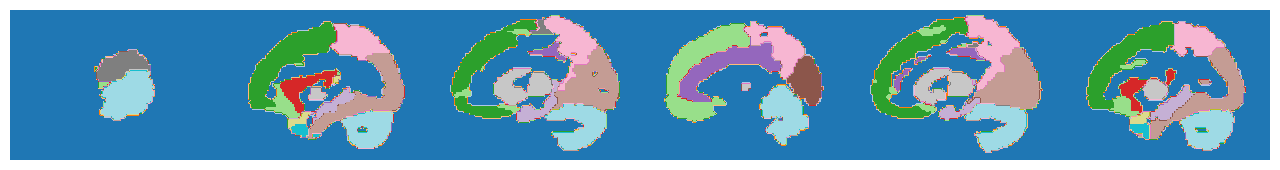

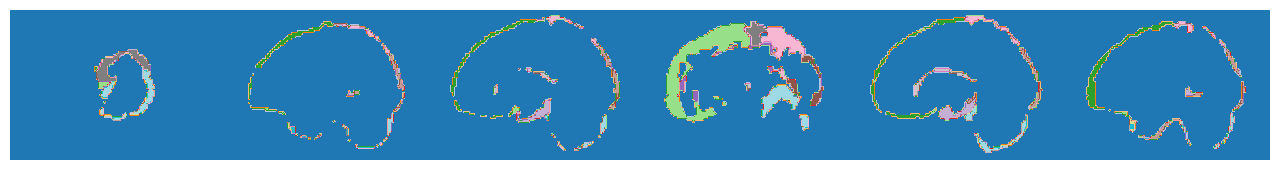

In [57]:
aal_transformed.plot(cmap="tab20",slices=plotslices)
(aal_transformed * (atropos_transformed == CSF)).plot(cmap="tab20", slices=plotslices)

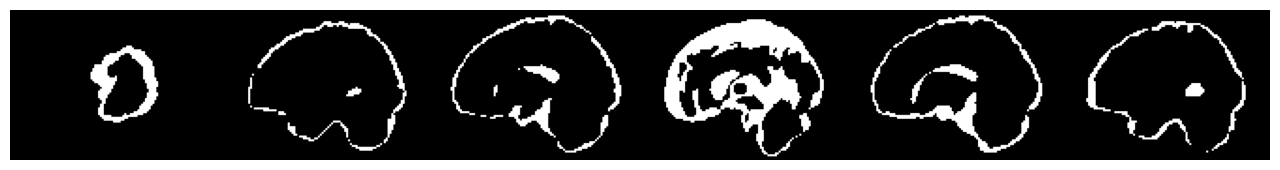

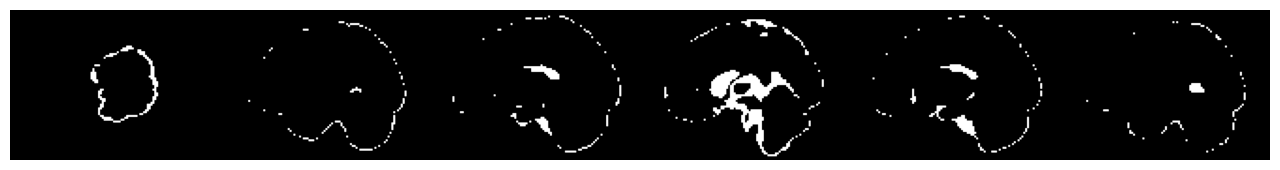

In [58]:
csf_label = (atropos_transformed  * BRAIN_MASK) == CSF
csf_label.plot(slices=plotslices)
csf_label = csf_label * (aal_transformed == 0) # Remove regions where there is an AAL labels 
csf_label.plot(slices=plotslices)

In [59]:
ATLAS = "AAL+CSF"

match ATLAS:
    case "AAL":
        parcellation = aal_transformed.numpy().astype(int)
        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        # Manually adding background
        parcellation_labels_map[0] = "background"
        parcellation_indices = np.unique(parcellation)
    case "AAL+CSF":
        parcellation = aal_transformed.numpy().astype(int)
        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        
        # Manually adding background + CSF
        parcellation_labels_map[0] = "background"
        
        # Including deep atropos CSF segmentation
        csf_label = (atropos_transformed  * BRAIN_MASK) == CSF
        csf_label = csf_label.numpy().astype(int)
        # Remove regions where there is an AAL labels 
        parcellation = csf_label * (parcellation == 0) + parcellation
        # I checked - there is n o label "1" in the given AAL
        parcellation_labels_map[1] = "CSF"
        
        parcellation_indices = np.unique(parcellation)
        
    case "AAL+Harvard":
        parcellation = aal_transformed.numpy().astype(int)
        subcorticals = harvard_subcortical_labels_transformed.numpy().astype(int)

        subcortical_mask = np.ones_like(subcorticals)
        skip_labels = [0,1,2, 12,13] # These look like cortical regions
        for i in skip_labels:
            subcortical_mask[subcortical_mask==i] = 0
        subcort_mask = subcortical_mask > 0

        parcellation = parcellation * ~subcort_mask + subcorticals * subcort_mask

        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        for i,label in enumerate(harvard_oxford_subcortical.labels):
            parcellation_labels_map[i] = label
        parcellation_indices = np.unique(parcellation)

    case "DKT":
        dkt_parcellation = dkt_post.numpy().astype(int)
        region_idxs = np.unique(dkt_parcellation)
    case _:
        print("SELECT VALID ATLAS")

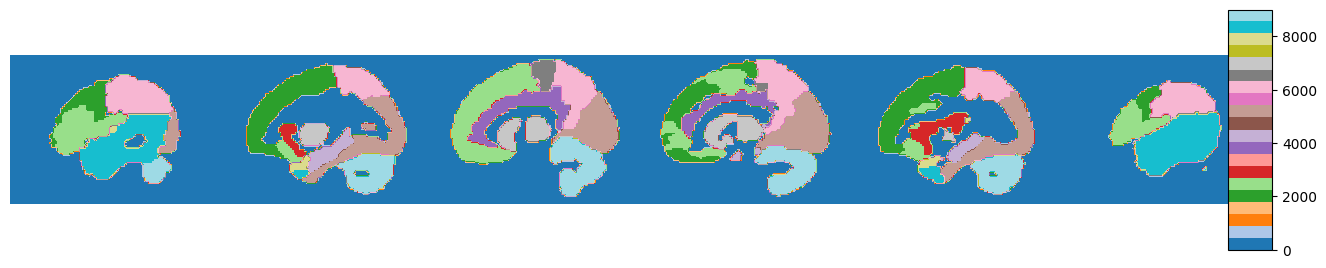

In [60]:
ants.from_numpy(parcellation.astype(float)).plot(nslices=6, cmap="tab20", cbar=True)

In [61]:
##### AntsPyNet DKT #######
# region_names = sorted(dkt_labels_flattened.values())
# reference_parcellation_scores = []

# for i, anomap in enumerate(reference_scores):
#     d = {dkt_labels_flattened[label_idx]:anomap[dkt_parcellation == label_idx].mean() for label_idx in region_idxs}
#     reference_parcellation_scores.append(d)
        
# reference_parcellation_scores = pd.DataFrame(reference_parcellation_scores)
# reference_parcellation_scores.head()

In [62]:
# parcellation_labels_map

In [63]:
len(parcellation_labels_map), len(parcellation_indices), parcellation.shape

(118, 118, (96, 112, 80))

In [64]:
%%time
region_names = sorted(parcellation_labels_map.values())
reference_parcellation_scores = []

for i, anomap in enumerate(reference_scores):
    d = {parcellation_labels_map[label_idx]: anomap[parcellation == label_idx].mean() for label_idx in parcellation_indices}
    reference_parcellation_scores.append(d)
        
reference_parcellation_scores = pd.DataFrame(reference_parcellation_scores)
reference_parcellation_scores.head()

CPU times: user 37.1 s, sys: 0 ns, total: 37.1 s
Wall time: 37.1 s


,background,CSF,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Cerebelum_10_L,Cerebelum_10_R,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10
0,-52.405773,-1.160594,-16.240721,-15.420356,-13.174262,-14.156552,-7.823804,-4.615128,-14.945374,-14.115917,...,0.274043,-1.931260,-2.772257,-1.809489,-12.854198,-9.614663,-10.075984,-9.784621,-13.246734,-0.820749
1,-53.402084,0.589674,-16.218039,-16.240524,-12.814417,-14.059655,-6.404531,-6.504943,-14.161819,-14.106808,...,1.904382,0.368827,0.593147,-7.963304,-8.854574,-13.252735,-10.851413,-9.404264,-8.134412,2.729643
2,-53.377735,0.354789,-16.782894,-15.423598,-13.801647,-13.938385,-6.296635,-6.754046,-14.851440,-14.423994,...,-2.394596,1.226850,2.177078,-3.667122,-8.187992,-14.593800,-17.832844,-13.660639,-9.626647,7.527297
3,-53.366486,-1.123906,-14.828829,-16.024061,-11.564390,-11.740133,-6.887378,-7.011018,-13.014995,-13.505042,...,-2.102789,-4.208999,-5.066557,-7.836586,-11.836378,-15.871938,-17.315775,-16.632887,-13.647439,-0.835417
4,-54.079800,-0.805278,-15.471673,-15.820292,-12.870411,-12.842586,-9.030422,-6.099383,-14.213899,-13.620967,...,-1.462058,-2.483546,-0.818634,-7.150911,-14.199053,-14.393287,-9.442236,-8.504608,-10.238399,2.698345


In [79]:
reference_parcellation_scores.to_csv(f"{workdir}/eval/heatmaps_v2/roi/training-{ATLAS}_roi_likelihoods.csv", index=None)

In [65]:
reference_parcellation_scores["CSF"].describe()

count    330.000000
mean      -1.157322
std        1.132608
min       -3.456014
25%       -2.045827
50%       -1.233784
75%       -0.422495
max        3.379874
Name: CSF, dtype: float64

In [66]:
percentileofscore(reference_parcellation_scores["CSF"], 2.0)

98.7878787878788

In [67]:
# %%time

# if ATLAS == "DKT":

#     region_names = sorted(dkt_labels_flattened.values())

#     for cohort, (filenames, scores) in cohort_data.items():
#         for i, anomap in enumerate(scores):
#             row_dict = {}

#             for label_idx in region_idxs:
#                 roi_name = dkt_labels_flattened[label_idx]
#                 raw_mean = anomap[dkt_parcellation == label_idx].mean()
#                 pct_score = percentileofscore(reference_parcellation_scores[roi_name], raw_mean)
#                 row_dict[roi_name] = pct_score
#             row_dict["Cohort"] = cohort
#             row_dict["ID"] = extract_ids(filenames[i]['image'])
#             region_scores.append(row_dict)


# region_scores = pd.DataFrame(region_scores)
# region_scores.head()

In [68]:
cohort_data = {
    "IBIS-DS": (ibis_ds_files, x_ds_scores_aligned),
    "IBIS-LR-Typical": (ibis_inlier_files, x_inlier_scores_aligned),
    "IBIS-HR-Typical": (ibis_hr_files, x_hr_inlier_scores_aligned),
    "IBIS-Atypical": (ibis_atyp_files, x_atypical_scores_aligned),
    "IBIS-ASD": (ibis_asd_files, x_asd_scores_aligned)
}

In [69]:
# %%time

# region_scores = []
# region_raw_likelihoods = []

# for cohort, (filenames, scores) in cohort_data.items():
#     for i, anomap in enumerate(scores):
#         row_dict = {}
        
#         for label_idx in parcellation_indices:
#             roi_name = parcellation_labels_map[label_idx]
#             raw_mean = anomap[parcellation == label_idx].mean()
#             pct_score = percentileofscore(reference_parcellation_scores[roi_name], raw_mean)
#             row_dict[roi_name] = pct_score
            
#         row_dict["Cohort"] = cohort
#         row_dict["ID"] = extract_ids(filenames[i]['image'])
#         region_scores.append(row_dict)

# region_scores = pd.DataFrame(region_scores)
# region_scores.head()

In [76]:
%%time

region_scores = []
region_raw_likelihoods = []
columns = [parcellation_labels_map[label_idx] for label_idx in parcellation_indices]
columns = columns + ['Cohort', "ID"]

for cohort, (filenames, scores) in cohort_data.items():
    for i, anomap in enumerate(scores):
        score_row, raw_row = [], []

        for label_idx in parcellation_indices:
            roi_name = parcellation_labels_map[label_idx]
            raw_mean = anomap[parcellation == label_idx].mean()
            pct_score = percentileofscore(reference_parcellation_scores[roi_name], raw_mean)
            score_row.append(pct_score)
            raw_row.append(raw_mean)
        
        sid = extract_ids(filenames[i]['image'])
        score_row.append(cohort)
        score_row.append(sid)
        region_scores.append(score_row)
        
        raw_row.append(cohort)
        raw_row.append(sid)
        region_raw_likelihoods.append(raw_row)

region_scores = pd.DataFrame(region_scores, columns=columns)
region_scores_raw = pd.DataFrame(region_raw_likelihoods, columns=columns)
region_scores.head()

CPU times: user 40.6 s, sys: 0 ns, total: 40.6 s
Wall time: 40.6 s


,background,CSF,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,...,Vermis_1_2,Vermis_3,Vermis_4_5,Vermis_6,Vermis_7,Vermis_8,Vermis_9,Vermis_10,Cohort,ID
0,100.000000,100.000000,99.696970,100.000000,100.000000,99.393939,99.393939,98.484848,99.393939,99.696970,...,14.242424,26.060606,89.090909,93.939394,85.757576,97.272727,73.030303,68.787879,IBIS-DS,IBIS105477
1,99.696970,97.878788,78.787879,90.909091,93.636364,97.575758,99.090909,98.787879,97.272727,99.393939,...,22.727273,16.666667,20.606061,45.757576,45.757576,45.151515,36.060606,35.757576,IBIS-DS,IBIS110925
2,88.484848,96.363636,24.242424,30.606061,47.272727,42.121212,79.696970,60.909091,60.909091,37.878788,...,6.969697,29.696970,13.030303,23.636364,57.575758,37.575758,70.909091,50.303030,IBIS-DS,IBIS123451
3,99.393939,97.878788,95.151515,98.787879,96.363636,98.787879,94.545455,89.393939,98.484848,98.787879,...,30.606061,14.545455,74.545455,92.121212,28.787879,7.878788,23.030303,50.303030,IBIS-DS,IBIS146443
4,99.393939,97.575758,64.242424,85.151515,97.575758,96.969697,90.000000,98.484848,96.363636,97.878788,...,1.818182,56.666667,71.818182,73.939394,87.878788,91.818182,19.090909,40.000000,IBIS-DS,IBIS241887


In [77]:
region_scores_raw.to_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods.csv", index=None)

In [71]:
# region_scores.to_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_scores.csv", index=None)

In [72]:
%ls -ailh /ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/roi/

total 668K
17181880799 drwxr-xr-x. 2 amahmood root   43 Mar  7 21:22 ./
14509287652 drwxr-xr-x. 5 amahmood root 4.0K Mar 14 19:00 ../
17181889637 -rw-r--r--. 1 amahmood root 663K Mar 12 15:50 AAL+CSF_roi_scores.csv


In [78]:
cohort_means = region_scores.pivot(columns='Cohort').mean()
diff = cohort_means.loc[:,'IBIS-DS']-cohort_means.loc[:,'IBIS-LR-Typical']
diff

/tmp/ipykernel_60988/4056218379.py:1: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



background       29.387340
CSF              32.033048
Precentral_L     25.037219
Precentral_R     25.333914
Frontal_Sup_L    32.148136
                   ...    
Vermis_6         35.487805
Vermis_7         29.380741
Vermis_8         31.507497
Vermis_9         24.593232
Vermis_10        18.508341
Length: 118, dtype: float64

In [ ]:
# inner_regions = list(filter(lambda c: c in dkt_labels["Inner labels"].values(),  region_scores.columns))
# sorted_regions = list(region_scores.query("Cohort == 'IBIS-DS'")[inner_regions].mean().sort_values(ascending=False).index)

In [ ]:
sorted_regions = list(diff.sort_values(ascending=False).index)
inner_scores = region_scores[sorted_regions+["Cohort"]]
data = inner_scores.melt(id_vars="Cohort", var_name="Region", value_name="Anomaly Score")
data.head()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2,1, figsize=(16,10))
ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[:10])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["IBIS-LR-Typical","IBIS-DS"], ax=axs[0],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right');

ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[10:20])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["IBIS-LR-Typical","IBIS-DS"], ax=axs[1],  width=0.35)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right');

In [ ]:
# outer_regions = list(filter(lambda c: c in dkt_labels["Outer labels"].values(),  region_scores.columns))
# sorted_regions = list(diff[outer_regions].sort_values(ascending=False).index)

# outer_scores = region_scores[sorted_regions+["Cohort"]]
# data = outer_scores.melt(id_vars="Cohort", var_name="Region", value_name="Anomaly Score")
# data.head()

In [ ]:
# fig, axs = plt.subplots(2,1, figsize=(16,10))
# ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[:10])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["IBIS-LR-Typical","IBIS-DS"], ax=axs[0],  width=0.35)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right');

# ax = sns.boxplot(data=data[data.Region.isin(sorted_regions[10:20])], x="Region", y="Anomaly Score", hue="Cohort", hue_order=["IBIS-LR-Typical","IBIS-DS"], ax=axs[1],  width=0.35)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right');

### Compute Lobe Score Norms

In [ ]:
aal_lobes = pd.read_csv('/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/aal_labels_lobe.csv')
aal_lobes

In [ ]:
parcellation.shape, x.shape

In [ ]:
x = x_asd_scores_aligned[0]

In [ ]:
%%time
aal_lobes_to_index = aal_lobes.groupby('Lobe')['ROI-Index']

lobe_data = {}
for cohort, (filenames, scores) in cohort_data.items():
    cohort_likelihoods = []
    for i, anomap in enumerate(scores):
        lobe_likelihoods = []
        for lobe, roi_idxs in aal_lobes_to_index:
            lobe_ll = np.concatenate([anomap[parcellation == idx] for idx in roi_idxs])
            lobe_ll = np.mean(lobe_ll)
            lobe_likelihoods.append(lobe_ll)
        cohort_likelihoods.append(np.asarray(lobe_likelihoods))
        
    lobe_data[cohort] = np.vstack(cohort_likelihoods)

In [ ]:
[l.shape for l in lobe_data.values()]

In [ ]:
np.savez_compressed(f"{workdir}/eval/heatmaps_v2/lobe_likelihoods.npz", **lobe_data)

In [ ]:
lobe_data.keys()